# OCT Scan Classification

In [ ]:
# import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader, random_split
from torchvision.datasets import DatasetFolder

# baseline model
from torchvision import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
from tqdm import tqdm


from collections import Counter


In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# transform image to get 128x128 RGB size
# add random roations, flips, crops, color changes
transform_data = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.RandomRotation(15),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomResizedCrop(128, scale=(0.8,1.0)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor()])

In [ ]:
oct_images = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360 Project Images/', transform=transform_data)
print("Number of Images:", len(oct_images))


# Count how many images belong to each class
class_counts = Counter(oct_images.targets)

# Print
for class_name, class_idx in oct_images.class_to_idx.items():
    print(f"{class_name}: {class_counts[class_idx]} images")


Number of Images: 6000
AMD: 1500 images
DME: 1500 images
DR: 1500 images
NO: 1500 images


## Split into Train, Val, and Test

In [ ]:
batch_size=32
train_split=0.7
val_split=0.15
test_split=0.15
oct_dataset=oct_images

# Compute lengths for each split
total_size = len(oct_dataset)
train_size = int(train_split * total_size)
val_size = int(val_split * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_data, val_data, test_data = random_split(
    oct_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(1000)  # for reproducibility
)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Training:", len(train_loader.dataset))
print("Validation:", len(val_loader.dataset))
print("Test:", len(test_loader.dataset))



Training: 4200
Validation: 900
Test: 900


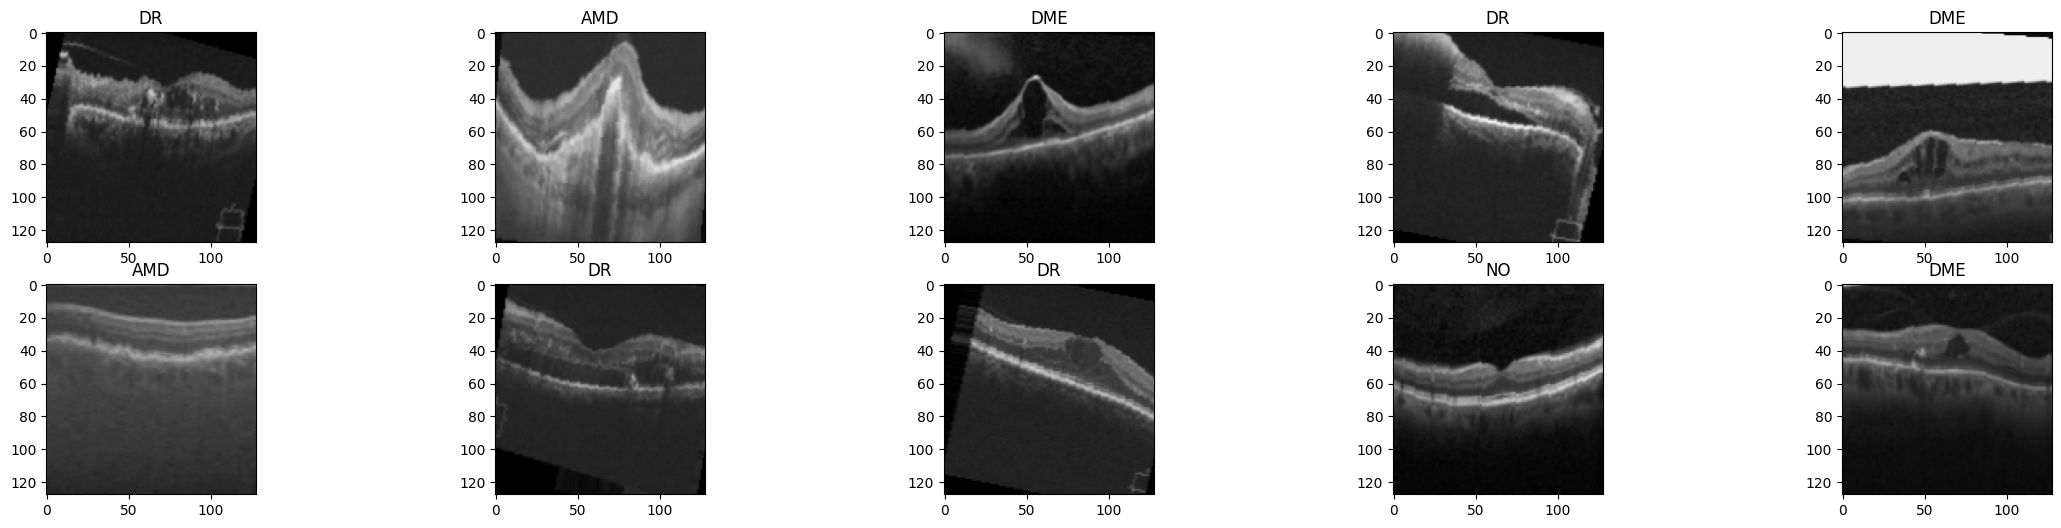

In [ ]:
# sanity check, print some imeages

# grab some sample images - load data in batches of 20, shuffle the images randomly
train_load = torch.utils.data.DataLoader(oct_images, batch_size=20, num_workers=1, shuffle=True)
images, labels = iter(train_load).__next__() # one batch of data from dataloader (first batch)
images = images.numpy()

# Folder names for the classes
classes = ['AMD', 'DME', 'DR', 'NO']

# Plot the images and class labels
figure = plt.figure(figsize=(28, 6)) # figure size (28 x 6 inches)
for i in np.arange(10):
    ax = figure.add_subplot(2, 5, i+1) # 2x5 column grid of subplots
    ax.set_title(classes[labels[i]])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))

## Baseline Model


Using device: cuda
Extracting train features...


Extracting features: 100%|██████████| 132/132 [00:56<00:00,  2.33it/s]


Extracting val features...


Extracting features: 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


Extracting test features...


Extracting features: 100%|██████████| 29/29 [01:51<00:00,  3.83s/it]


Feature extraction complete.
Training Random Forest...
Training complete.

Random Forest Accuracy (Test): 0.7500

Classification Report:
              precision    recall  f1-score   support

         AMD       0.73      0.76      0.75       216
         DME       0.65      0.67      0.66       226
          DR       0.87      0.94      0.90       227
          NO       0.74      0.63      0.68       231

    accuracy                           0.75       900
   macro avg       0.75      0.75      0.75       900
weighted avg       0.75      0.75      0.75       900



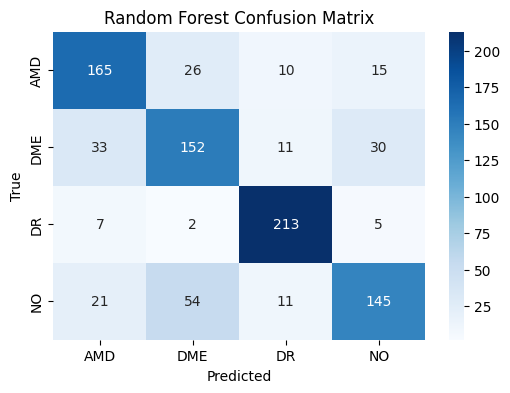

In [ ]:

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


#  Load pretrained ResNet18 as feature extractor
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()  # remove final classification layer
resnet = resnet.to(device)
resnet.eval()

def extract_features(dataloader):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Extracting features"):
            imgs = imgs.to(device)
            feats = resnet(imgs).cpu().numpy()
            features_list.append(feats)
            labels_list.append(labels.numpy())
    return np.concatenate(features_list), np.concatenate(labels_list)



print("Extracting train features...")
X_train, y_train = extract_features(train_loader)
print("Extracting val features...")
X_val, y_val = extract_features(val_loader)
print("Extracting test features...")
X_test, y_test = extract_features(test_loader)
print("Feature extraction complete.")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training Random Forest...")
rf.fit(X_train, y_train)
print("Training complete.")

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nRandom Forest Accuracy (Test): {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['AMD','DME','DR','NO']))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['AMD','DME','DR','NO'],
            yticklabels=['AMD','DME','DR','NO'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()


## CNN Model


In [ ]:
class OCTCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(OCTCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # Input: 3x128x128 -> 32x128x128
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)  # 32x64x64 -> 64x64x64 after pooling

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # halves spatial dimensions each time

        self.fc1 = nn.Linear(48*16*16, 256)  # 12,288 -> 256
        self.fc2 = nn.Linear(256, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # 128 -> 64

        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 64 -> 32
        x = self.pool(x)  # second pool to reduce 32 -> 16 spatial size

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Training & Accuracy

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

    model.train()
    accuracy = correct / total
    return accuracy


def train_model(model, train_data, validation_data, batch_size=32, epochs=10, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print(f"\nUsing device: {device}")
    print(f"Starting training for {epochs} epochs...\n")

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    torch.manual_seed(50)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = 0, [], [], []

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1
            iters += 1

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        current_train_acc = get_accuracy(model, train_loader)
        current_val_acc = get_accuracy(model, validation_loader)
        train_acc.append(current_train_acc)
        val_acc.append(current_val_acc)

        print(f"Epoch [{epoch + 1}/{epochs}] "
              f"| Avg Loss: {avg_loss:.4f} "
              f"| Train Acc: {current_train_acc:.4f} "
              f"| Val Acc: {current_val_acc:.4f}")

    print("\nTraining complete!\n")

    # Plot Accuracy
    plt.figure()
    plt.title("Training vs Validation Accuracy")
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.figure()
    plt.title("Training Loss Over Time")
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


## Overfit


Using device: cuda
Epoch [1/200], Loss: 1.7766, Training Accuracy: 0.3000
Epoch [2/200], Loss: 1.7660, Training Accuracy: 0.3500
Epoch [3/200], Loss: 1.7614, Training Accuracy: 0.4500
Epoch [4/200], Loss: 1.7499, Training Accuracy: 0.2500
Epoch [5/200], Loss: 1.7278, Training Accuracy: 0.2500
Epoch [6/200], Loss: 1.7159, Training Accuracy: 0.3000
Epoch [7/200], Loss: 1.6742, Training Accuracy: 0.3000
Epoch [8/200], Loss: 1.6654, Training Accuracy: 0.3000
Epoch [9/200], Loss: 1.6047, Training Accuracy: 0.3000
Epoch [10/200], Loss: 1.5524, Training Accuracy: 0.3000
Epoch [11/200], Loss: 1.5812, Training Accuracy: 0.3000
Epoch [12/200], Loss: 1.4539, Training Accuracy: 0.3500
Epoch [13/200], Loss: 1.4420, Training Accuracy: 0.3500
Epoch [14/200], Loss: 1.3478, Training Accuracy: 0.4000
Epoch [15/200], Loss: 1.3276, Training Accuracy: 0.4000
Epoch [16/200], Loss: 1.4167, Training Accuracy: 0.2500
Epoch [17/200], Loss: 1.5998, Training Accuracy: 0.3500
Epoch [18/200], Loss: 1.3595, Training

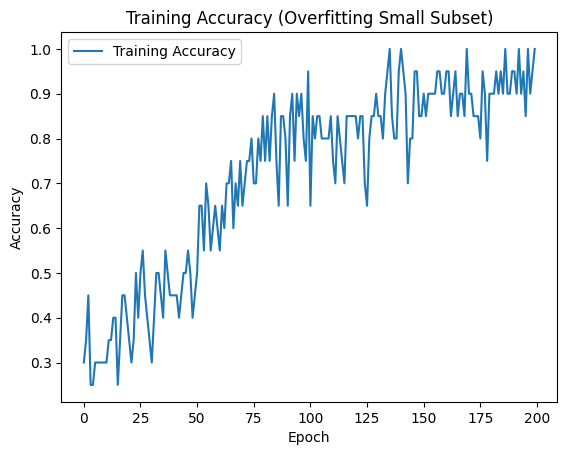

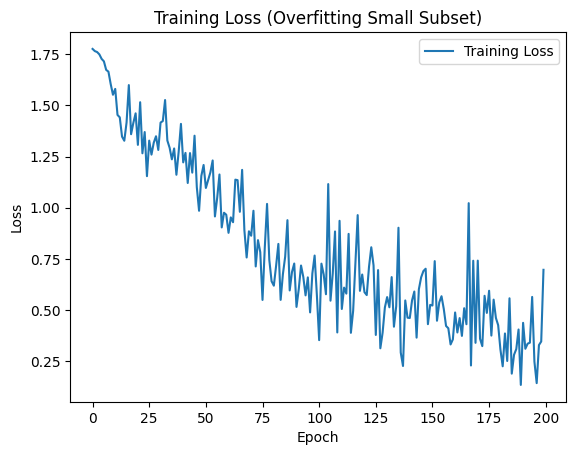

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt

# small random subset of the training data
subset_size = 20

#  train_data is defined from previous steps
if len(train_data) < subset_size:
    print(f"Warning: train_data has only {len(train_data)} samples, using full dataset instead.")
    small_subset_indices = list(range(len(train_data)))
else:
    small_subset_indices = random.sample(range(len(train_data)), subset_size)

small_dataset = Subset(train_data, small_subset_indices)

# DataLoader for the small subset
small_loader = DataLoader(small_dataset, batch_size=subset_size, shuffle=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model, loss, optimizer

torch.manual_seed(50)
myModel = OCTCNN()  # Make sure OCTCNN is defined
myModel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.01, momentum=0.9)

# Accuracy helper function
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)
    model.train()
    return correct / total if total > 0 else 0

# Training loop (overfitting small subset)
iters, losses, train_acc = 0, [], []

num_epochs = 200
for epoch in range(num_epochs):
    myModel.train()
    epoch_loss = 0
    num_batches = 0

    for images, labels in small_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = myModel(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1
        iters += 1

    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
    losses.append(avg_loss)

    current_train_acc = get_accuracy(myModel, small_loader)
    train_acc.append(current_train_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {current_train_acc:.4f}')

# Plot training accuracy
plt.figure()
plt.title("Training Accuracy (Overfitting Small Subset)")
plt.plot(train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss
plt.figure()
plt.title("Training Loss (Overfitting Small Subset)")
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
results = {}

modelA = OCTCNN()

if torch.cuda.is_available():
    modelA.cuda()
    print('We are utilizing the GPU')
else:
    print('We are not utilizing the GPU')

results['A'] = train_model(modelA, train_data, val_data, batch_size=128, lr=0.01, epochs=15)

We are utilizing the GPU

Using device: cuda
Starting training for 15 epochs...

Epoch [1/15] | Avg Loss: 1.3729 | Train Acc: 0.3826 | Val Acc: 0.4000
Epoch [2/15] | Avg Loss: 1.2418 | Train Acc: 0.5464 | Val Acc: 0.5500
Epoch [3/15] | Avg Loss: 1.0556 | Train Acc: 0.6214 | Val Acc: 0.6144


We are utilizing the GPU

Using device: cuda
Starting training for 20 epochs...

Epoch [1/20] | Avg Loss: 1.6474 | Train Acc: 0.2740 | Val Acc: 0.2689
Epoch [2/20] | Avg Loss: 1.4033 | Train Acc: 0.3624 | Val Acc: 0.3844
Epoch [3/20] | Avg Loss: 1.3506 | Train Acc: 0.4295 | Val Acc: 0.4222
Epoch [4/20] | Avg Loss: 1.3075 | Train Acc: 0.4557 | Val Acc: 0.4789
Epoch [5/20] | Avg Loss: 1.2608 | Train Acc: 0.4567 | Val Acc: 0.4633
Epoch [6/20] | Avg Loss: 1.2012 | Train Acc: 0.5362 | Val Acc: 0.5667
Epoch [7/20] | Avg Loss: 1.1563 | Train Acc: 0.5538 | Val Acc: 0.5456
Epoch [8/20] | Avg Loss: 1.1091 | Train Acc: 0.5557 | Val Acc: 0.5722
Epoch [9/20] | Avg Loss: 1.0567 | Train Acc: 0.6067 | Val Acc: 0.6244
Epoch [10/20] | Avg Loss: 1.0121 | Train Acc: 0.6298 | Val Acc: 0.6233
Epoch [11/20] | Avg Loss: 0.9631 | Train Acc: 0.6290 | Val Acc: 0.6278
Epoch [12/20] | Avg Loss: 0.9398 | Train Acc: 0.6336 | Val Acc: 0.6389
Epoch [13/20] | Avg Loss: 0.9018 | Train Acc: 0.6571 | Val Acc: 0.6589
Epoch

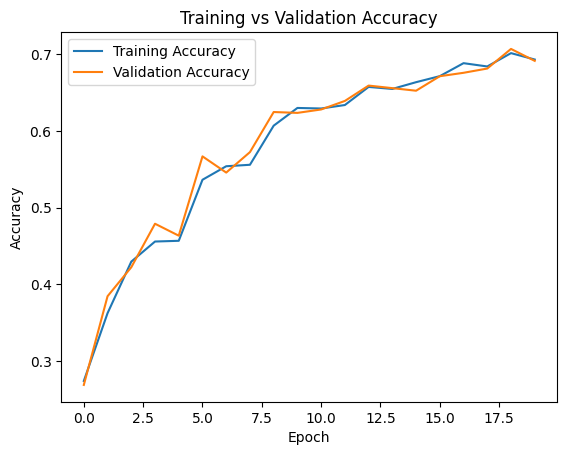

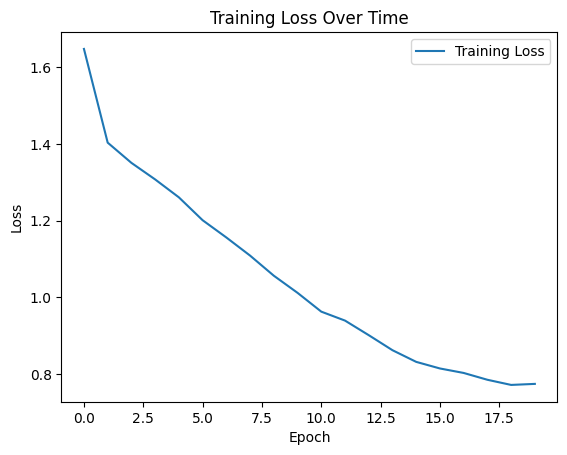

In [ ]:
# Initialize results dictionary if not already
results = {}

# Model B
modelB = OCTCNN()

# Move model to GPU if available
if torch.cuda.is_available():
    modelB.cuda()
    print('We are utilizing the GPU')
else:
    print('We are not utilizing the GPU')

# Train Model B with different hyperparameters
results['B'] = train_model(
    modelB,
    train_data,
    val_data,
    batch_size=64,      # smaller batch size
    lr=0.001,           # lower learning rate
    epochs=20           # more epochs
)


We are utilizing the GPU

Using device: cuda
Starting training for 25 epochs...

Epoch [1/25] | Avg Loss: 1.7361 | Train Acc: 0.2529 | Val Acc: 0.2467
Epoch [2/25] | Avg Loss: 1.5873 | Train Acc: 0.2529 | Val Acc: 0.2467
Epoch [3/25] | Avg Loss: 1.4599 | Train Acc: 0.2748 | Val Acc: 0.2656
Epoch [4/25] | Avg Loss: 1.4139 | Train Acc: 0.2907 | Val Acc: 0.2878
Epoch [5/25] | Avg Loss: 1.3942 | Train Acc: 0.3371 | Val Acc: 0.3567
Epoch [6/25] | Avg Loss: 1.3771 | Train Acc: 0.3183 | Val Acc: 0.3356
Epoch [7/25] | Avg Loss: 1.3724 | Train Acc: 0.3214 | Val Acc: 0.3222
Epoch [8/25] | Avg Loss: 1.3519 | Train Acc: 0.3686 | Val Acc: 0.3933
Epoch [9/25] | Avg Loss: 1.3402 | Train Acc: 0.4093 | Val Acc: 0.4156
Epoch [10/25] | Avg Loss: 1.3291 | Train Acc: 0.4500 | Val Acc: 0.4744
Epoch [11/25] | Avg Loss: 1.3135 | Train Acc: 0.4252 | Val Acc: 0.4544
Epoch [12/25] | Avg Loss: 1.3060 | Train Acc: 0.4298 | Val Acc: 0.4389
Epoch [13/25] | Avg Loss: 1.2880 | Train Acc: 0.4505 | Val Acc: 0.4556
Epoch

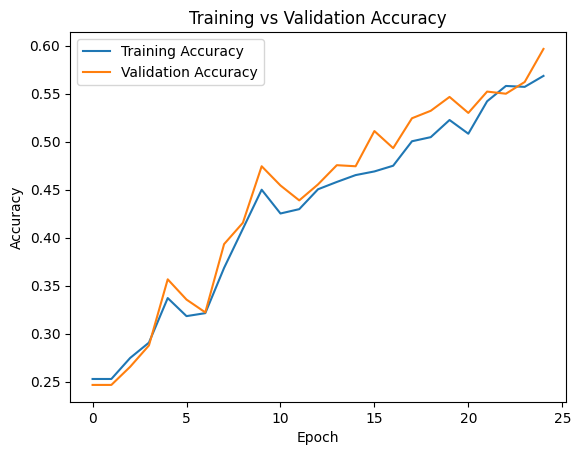

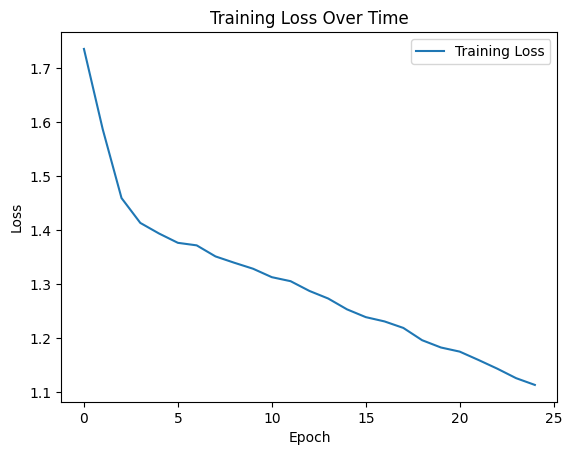

In [ ]:
# Model C
modelC = OCTCNN()

if torch.cuda.is_available():
    modelC.cuda()
    print('We are utilizing the GPU')
else:
    print('We are not utilizing the GPU')

# Train Model C
results['C'] = train_model(
    modelC,
    train_data,
    val_data,
    batch_size=128,
    lr=0.0005,
    epochs=25)


## Test Best Model (A)

In [ ]:
test_load = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True)
print(get_accuracy(modelC, test_load))